In [ ]:
from google.colab import files
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build
from google.colab import drive
from google.colab.patches import cv2_imshow

from io import BytesIO

import numpy as np

import pandas as pd

import sys, os, re, csv, codecs
from os import listdir

import tensorflow as tf

import cv2

import keras
from keras import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras import models
from keras.models import model_from_json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.data_utils import get_file
from keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import skimage

import scipy
from scipy import ndimage, misc

from PIL import Image

import glob

import sklearn
from sklearn.metrics import confusion_matrix

import imutils


In [ ]:
import torch

In [ ]:
torch.cuda.device_count()

1

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
tf.compat.v2
print(tf.__version__)

2.8.0


In [ ]:
#from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss
from numpy import genfromtxt

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Creating the new dataset composed by multi-channels files

mu1

In [ ]:
import os, glob
from collections import defaultdict

dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated 2vs2/mu1/real', '/content/drive/MyDrive/Colab Notebooks/Simulated 2vs2/mu1/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/Dataset 2vs2/mu1'
for unique_filename, copies in unique_files.items():
  arr= np.concatenate([genfromtxt(copy, delimiter=',') for copy in copies],axis=1)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)

print(arr.shape)

(71, 22)


mu5

In [ ]:
dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated 2vs2/mu5/real', '/content/drive/MyDrive/Colab Notebooks/Simulated 2vs2/mu5/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/Dataset 2vs2/mu5'
for unique_filename, copies in unique_files.items():
  arr= np.concatenate([genfromtxt(copy, delimiter=',') for copy in copies], axis=1)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)
print(arr.shape)

(71, 22)


# Dataset 2 classes

In [ ]:
new_root_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset 2vs2'

In [ ]:
#Let's start by importing the libraries needed
import os
from sklearn.utils import shuffle
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np
from matplotlib import cm

In [ ]:
def preprocessing(path,path_mu1, path_mu5):
 imgs_array = []
 label_array = []
 cartelle = [j for j in sorted(os.listdir(path))]

 for folder in cartelle:
   if folder.startswith('mu1'): #if the image's name starts with "mu1" then the label will be 0
     immagini_mu1 = [i for i in sorted(os.listdir(path_mu1))]
     for image in immagini_mu1:
       images = np.load(os.path.join(path_mu1, image))
       #images = images.reshape(71,22,1)
       #images = img_to_array(images)
       label_array.append(1)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('mu5'): #if the image's name starts with "cat" then the label will be 0
     immagini_mu5 = [i for i in sorted(os.listdir(path_mu5))]
     for image in immagini_mu5:
       images = np.load(os.path.join(path_mu5, image), allow_pickle= True)
       #images = images.reshape(71,22,1)

       #images = img_to_array(images)
       label_array.append(5)
       imgs_array.append(images) #images are added to a list



     #imgs_array = np.asarray(imgs_array) #data are converted to an array
     #label_array = np.asarray(label_array)

 return imgs_array, label_array

In [ ]:
from sklearn.utils import shuffle
path_mu1= "/content/drive/MyDrive/Colab Notebooks/Dataset 2vs2/mu1"
path_mu5= "/content/drive/MyDrive/Colab Notebooks/Dataset 2vs2/mu5"



#preprocessing and shuffle
new_array_2vs2, new_label_2vs2 = preprocessing(new_root_dir,path_mu1, path_mu5)
new_array_2vs2, new_label_2vs2 = shuffle(new_array_2vs2,new_label_2vs2,random_state=24) #Random state allows to obtain the same shuffle over time

(71, 22)
5
(71, 22)
1


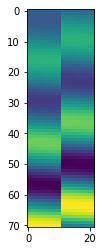

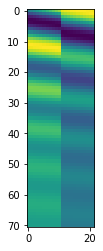

In [ ]:
plt.figure()
print(new_array_2vs2[50].shape)
#print(new_label[20].shape)
img=np.reshape(new_array_2vs2[50], (71, 22))
plt.imshow(img)
print(new_label_2vs2[50])

plt.figure()
print(new_array_2vs2[400].shape)
#print(new_label[20].shape)
img=np.reshape(new_array_2vs2[400], (71, 22))
plt.imshow(img)
print(new_label_2vs2[400])

In [ ]:
from sklearn.model_selection import train_test_split

#split in dataset in train-test
X_train_2vs2, X_test_2vs2, y_train_2vs2, y_test_2vs2 = train_test_split(new_array_2vs2,new_label_2vs2, test_size=0.20, stratify=new_label_2vs2, random_state=42)

#split train in train-valid
Xtrain_2vs2, Xvalid_2vs2, ytrain_2vs2, yvalid_2vs2 = train_test_split(X_train_2vs2,y_train_2vs2, test_size=0.30, stratify=y_train_2vs2, random_state=42)

In [ ]:
print("Dataset Split:")
print(f"Training : {len(Xtrain_2vs2)}")
print(f"Validation : {len(Xvalid_2vs2)}")
print(f"Testing : {len(X_test_2vs2)}")

Dataset Split:
Training : 560
Validation : 240
Testing : 200


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
Xtrain_2vs2 = np.asarray(Xtrain_2vs2)
ytrain_2vs2 = np.asarray(ytrain_2vs2)
ytrain_2vs2 = ytrain_2vs2.reshape(-1, 1)
X_test_2vs2 = np.asarray(X_test_2vs2)
y_test_2vs2 = np.asarray(y_test_2vs2)
y_test_2vs2 = y_test_2vs2.reshape(-1, 1)
yvalid_2vs2 = np.asarray(yvalid_2vs2)
yvalid_2vs2 = yvalid_2vs2.reshape(-1, 1)
Xvalid_2vs2 = np.asarray(Xvalid_2vs2)

encoder = OrdinalEncoder()
ytrain_2vs2 = encoder.fit_transform(ytrain_2vs2)

yvalid_2vs2 = encoder.fit_transform(yvalid_2vs2)

y_test_2vs2 = encoder.fit_transform(y_test_2vs2)


In [ ]:
from sklearn.preprocessing import label_binarize
y_test_2vs2_1 = label_binarize(y_test_2vs2, classes=[0,1])
yvalid_2vs2_1 = label_binarize(yvalid_2vs2, classes=[0,1])
ytrain_2vs2_1 = label_binarize(ytrain_2vs2, classes=[0,1])
print(ytrain_2vs2_1[50])

[1]


In [ ]:
print(Xvalid_2vs2.shape)
print(yvalid_2vs2_1[50])

(240, 71, 22)
[1]


In [ ]:
#This is just an example of data augmentation: there are so many functions that you can use!
import tensorflow as tf

def flip_axis(x, axis):
    cp = np.copy(x)
    cp = np.asarray(cp).swapaxes(axis, 0)
    cp = cp[::-1, ...]
    cp = cp.swapaxes(0, axis)
    return cp


def augment_data(dataset, dataset_labels, augementation_factor=1, use_flip_axis=True, use_random_rotation=True, use_random_shear=True, use_random_shift=True, use_random_brightness= True):
    augmented_image = []
    augmented_image_labels = []

    for num in range (0, dataset.shape[0]):
			# original image:
       augmented_image.append(dataset[num])
       augmented_image_labels.append(dataset_labels[num])

       for i in range(0, augementation_factor):

            # flipping
            if use_flip_axis:
                augmented_image.append(flip_axis(dataset[num],1))
                augmented_image_labels.append(dataset_labels[num])

            #random rotation
            #if use_random_rotation:
               # augmented_image.append(tf.keras.preprocessing.image.random_rotation(dataset[num], 40, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                #augmented_image_labels.append(dataset_labels[num])
            if use_random_rotation:
                augmented_image.append(tf.keras.preprocessing.image.random_rotation(dataset[num], 180, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                augmented_image_labels.append(dataset_labels[num])
            #random spatial shear
            if use_random_shear:
                augmented_image.append(tf.keras.preprocessing.image.random_shear(dataset[num], 0.2, row_axis=0, col_axis=1, channel_axis=0))
                augmented_image_labels.append(dataset_labels[num])
            #random spatial shift
            if use_random_shift:
                augmented_image.append(tf.keras.preprocessing.image.random_shift(dataset[num], 0.2, 0.2, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                augmented_image_labels.append(dataset_labels[num])
            if use_random_brightness:
               augmented_image.append(tf.keras.preprocessing.image.random_brightness(dataset[num], [0.2, 0.5]))
               augmented_image_labels.append(dataset_labels[num])

    return np.array(augmented_image), np.array(augmented_image_labels)


In [ ]:
print(img_augmented_2vs2.shape)
print(Xtrain_2vs2.shape)

In [ ]:
plt.subplot(121)
img=np.reshape(img_augmented_2vs2[34], (71, 22))
plt.imshow(img)
print(label_augmented_2vs2[34])

plt.subplot(122)
img=np.reshape(img_augmented_2vs2[34], (71, 22))
plt.imshow(img)
print(label_augmented_2vs2[34])

In [ ]:
#model with 71x22 images
from keras.layers import GaussianNoise
def create_model_2vs2():
  model = models.Sequential([

    layers.Conv2D(64, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    #model.add(layers.GaussianNoise(0.1))
    layers.Dense(2, activation='softmax'),
  ])
  return model

# Create a basic model instance
model_2vs2 = create_model_2vs2()

# Show a summary of the model. Check the number of trainable parameters
model_2vs2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 20, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 69, 20, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 10, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 21760)             0         
                                                                 
 dense (Dense)               (None, 1024)              22283264  
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [ ]:
# This function keeps the initial learning rate for the first 5 epochs
# and decreases it exponentially after that.
def scheduler(num_epoch, lr):
  if num_epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
num_epochs = 30
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


model_2vs2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_2vs2.fit(Xtrain_2vs2, ytrain_2vs2, epochs=num_epochs, callbacks= [callback], batch_size=16, validation_data=(Xvalid_2vs2, yvalid_2vs2), verbose=1)


Epoch 1/30
35/35 [==============================] - 2s 22ms/step - loss: 1.3670 - accuracy: 0.6964 - val_loss: 0.5946 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/30
35/35 [==============================] - 0s 11ms/step - loss: 1.3922 - accuracy: 0.7500 - val_loss: 0.5583 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 3/30
35/35 [==============================] - 0s 11ms/step - loss: 1.2350 - accuracy: 0.7768 - val_loss: 0.5429 - val_accuracy: 0.7542 - lr: 1.0000e-04
Epoch 4/30
35/35 [==============================] - 0s 12ms/step - loss: 1.0699 - accuracy: 0.7839 - val_loss: 0.4984 - val_accuracy: 0.8375 - lr: 1.0000e-04
Epoch 5/30
35/35 [==============================] - 0s 12ms/step - loss: 1.0213 - accuracy: 0.7714 - val_loss: 0.5069 - val_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 6/30
35/35 [==============================] - 0s 12ms/step - loss: 0.8533 - accuracy: 0.8054 - val_loss: 0.4906 - val_accuracy: 0.7792 - lr: 9.0484e-05
Epoch 7/30
35/35 [==============================] - 

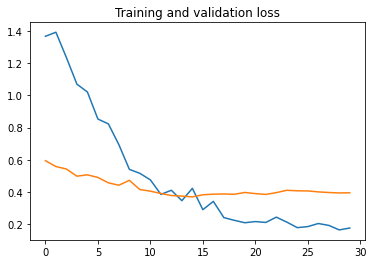

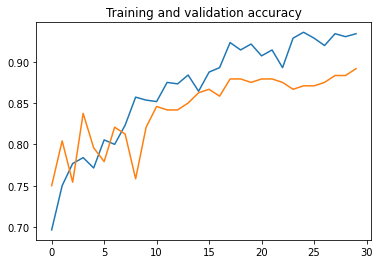

In [ ]:
import matplotlib.pyplot as plt

epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")

              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91       100
         1.0       0.87      0.97      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.91       200

accuracy: 0.915
1
1


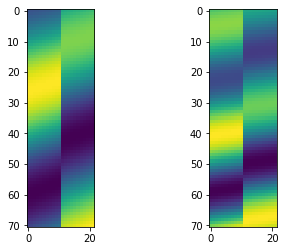

In [ ]:
#results:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#y_pred = model.predict_classes(X_test)
y_pred_2vs2 = np.argmax(model_2vs2.predict(X_test_2vs2),1)


print(sklearn.metrics.classification_report(y_test_2vs2, y_pred_2vs2))
a = accuracy_score(y_test_2vs2, y_pred_2vs2)
print("accuracy:",a)
plt.subplot(121)
img=np.reshape(X_test_2vs2[20], (71, 22))
plt.imshow(img)

print(y_pred_2vs2[20])
plt.subplot(122)
img_1=np.reshape(X_test_2vs2[4], (71, 22))
plt.imshow(img_1)
print(y_pred_2vs2[4])

In [ ]:
y_predicted_2vs2 = model_2vs2.predict(X_test_2vs2) #predict will return the scores of the model and predict_class will return the class of your predictions. Although it seems similar there are some differences:
pred_class_2vs2 = np.argmax(y_predicted_2vs2, axis=1)  #argmax tra le colonne (axis =1)
#print(y_predicted)
#print(pred_class)

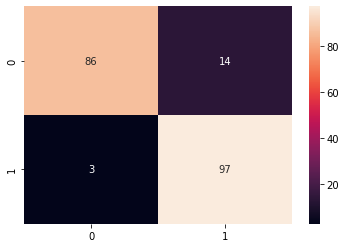

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test_2vs2, pred_class_2vs2)
#print(conf)
sns.heatmap(conf, annot=True, fmt="d")

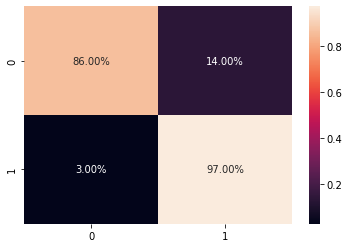

In [ ]:
cm = conf.astype('float') / conf.sum(axis=1)
sns.heatmap(cm, annot=True,
            fmt='.2%')

In [ ]:
from sklearn.metrics import roc_curve

fpr_model_2vs2, tpr_model_2vs2, thresholds_model_2vs2 = roc_curve(y_test_2vs2, y_predicted_2vs2[:,1])

In [ ]:
from sklearn.metrics import auc
auc_model_2vs2 = auc(fpr_model_2vs2, tpr_model_2vs2)

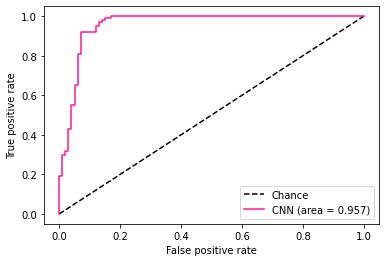

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.plot(fpr_model_2vs2, tpr_model_2vs2, color='deeppink', label='CNN (area = {:.3f})'.format(auc_model_2vs2))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend(loc='best')
plt.show()


In [ ]:
#model with 71x22 images
from keras.layers import GaussianNoise
def create_model_2_a():
  model = models.Sequential([

    layers.Conv2D(32, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),


    layers.Dense(5, activation='softmax'),
  ])
  return model

# Create a basic model instance
model_2_a = create_model_2_a()

# Show a summary of the model. Check the number of trainable parameters
model_2_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 69, 20, 32)        320       
                                                                 
 batch_normalization_1 (Batc  (None, 69, 20, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 8, 64)         18496     
                                                                 
 batch_normalization_2 (Batc  (None, 32, 8, 64)        256       
 hNormalization)                                                 
                                                      

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.

def scheduler(num_epoch, lr):
  if num_epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
num_epochs = 30

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_2_a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])



history = model_2_a.fit(Xtrain_2vs2, ytrain_2vs2, epochs=num_epochs, callbacks= [callback], batch_size=16, validation_data=(Xvalid_2vs2, yvalid_2vs2), verbose=1)


Epoch 1/30
35/35 [==============================] - 13s 20ms/step - loss: 1.3871 - accuracy: 0.6304 - val_loss: 1.4121 - val_accuracy: 0.7875 - lr: 1.0000e-04
Epoch 2/30
35/35 [==============================] - 0s 11ms/step - loss: 0.7369 - accuracy: 0.7571 - val_loss: 1.2988 - val_accuracy: 0.7542 - lr: 1.0000e-04
Epoch 3/30
35/35 [==============================] - 0s 11ms/step - loss: 0.5222 - accuracy: 0.8304 - val_loss: 1.1558 - val_accuracy: 0.6625 - lr: 1.0000e-04
Epoch 4/30
35/35 [==============================] - 0s 11ms/step - loss: 0.5765 - accuracy: 0.8018 - val_loss: 1.0712 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/30
35/35 [==============================] - 0s 11ms/step - loss: 0.4631 - accuracy: 0.8429 - val_loss: 1.0795 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/30
35/35 [==============================] - 0s 12ms/step - loss: 0.3505 - accuracy: 0.8750 - val_loss: 1.1805 - val_accuracy: 0.5000 - lr: 9.0484e-05
Epoch 7/30
35/35 [==============================] -

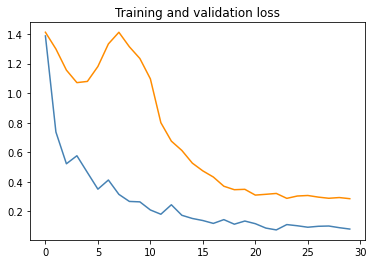

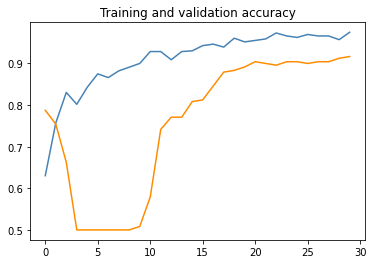

In [ ]:
import matplotlib.pyplot as plt

epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs),history.history["loss"], label="train_loss", color= 'steelblue')
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss", color='darkorange')

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc",  color='steelblue')
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc",  color='darkorange')

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       100
         1.0       0.91      0.97      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200

accuracy: 0.935
1
1


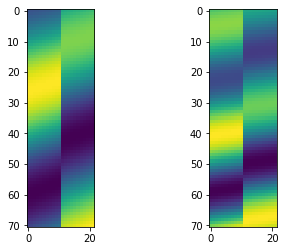

In [ ]:
#results:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#y_pred = model.predict_classes(X_test)
y_pred_exp= np.argmax(model_2_a.predict(X_test_2vs2, batch_size=16),1)


print(sklearn.metrics.classification_report(y_test_2vs2, y_pred_exp))
a = accuracy_score(y_test_2vs2, y_pred_exp)
print("accuracy:",a)
plt.subplot(121)
img=np.reshape(X_test_2vs2[20], (71, 22))
plt.imshow(img)

print(y_pred_exp[20])
plt.subplot(122)
img_1=np.reshape(X_test_2vs2[4], (71, 22))
plt.imshow(img_1)
print(y_pred_exp[4])

# Creating the new dataset composed by multi-channels files

mu1

In [ ]:
import os, glob
from collections import defaultdict

dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated pt2/mu1/real', '/content/drive/MyDrive/Colab Notebooks/Simulated pt2/mu1/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu1'
for unique_filename, copies in unique_files.items():
  arr= np.concatenate([genfromtxt(copy, delimiter=',') for copy in copies],axis=1)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)

print(arr.shape)

(71, 22)


mu2

In [ ]:
dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated pt2/mu2/real', '/content/drive/MyDrive/Colab Notebooks/Simulated pt2/mu2/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu2'
for unique_filename, copies in unique_files.items():
  arr= np.concatenate([genfromtxt(copy, delimiter=',') for copy in copies], axis=1)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)
print(arr.shape)

(71, 22)


mu3

In [ ]:
dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated pt2/mu3/real', '/content/drive/MyDrive/Colab Notebooks/Simulated pt2/mu3/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu3'
for unique_filename, copies in unique_files.items():
  arr= np.concatenate([genfromtxt(copy, delimiter=',') for copy in copies], axis=1)

  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)
print(arr.shape)

(71, 22)


mu4

In [ ]:
dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated pt2/mu4/real', '/content/drive/MyDrive/Colab Notebooks/Simulated pt2/mu4/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu4'
for unique_filename, copies in unique_files.items():
  arr= np.concatenate([genfromtxt(copy, delimiter=',') for copy in copies], axis=1)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)
print(arr.shape)

(71, 22)


mu5

In [ ]:
dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated pt2/mu5/real', '/content/drive/MyDrive/Colab Notebooks/Simulated pt2/mu5/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu5'
for unique_filename, copies in unique_files.items():
  arr= np.concatenate([genfromtxt(copy, delimiter=',') for copy in copies], axis=1)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)
print(arr.shape)

(71, 22)


In [ ]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset'

# Dataset

In [ ]:
new_root_dir = '/content/drive/MyDrive/Colab Notebooks/New_Dataset'

In [ ]:
#Let's start by importing the libraries needed
import os
from sklearn.utils import shuffle
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np
from matplotlib import cm

In [ ]:
def preprocessing(path,path_mu1, path_mu2, path_mu3, path_mu4, path_mu5):
 imgs_array = []
 label_array = []
 cartelle = [j for j in sorted(os.listdir(path))]

 for folder in cartelle:
   if folder.startswith('mu1'): #if the image's name starts with "mu1" then the label will be 0
     immagini_mu1 = [i for i in sorted(os.listdir(path_mu1))]
     for image in immagini_mu1:
       images = np.load(os.path.join(path_mu1, image))
       #images = images.transpose((1, 2, 0))
       #images = img_to_array(images)
       label_array.append(1)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('mu2'): #if the image's name starts with "cat" then the label will be 0
     immagini_mu2 = [i for i in sorted(os.listdir(path_mu2))]
     for image in immagini_mu2:
       images = np.load(os.path.join(path_mu2, image), allow_pickle= True)
       #images = images.transpose((1, 2, 0))

       #images = img_to_array(images)
       label_array.append(2)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('mu3'): #if the image's name starts with "cat" then the label will be 0
     immagini_mu3 = [i for i in sorted(os.listdir(path_mu3))]
     for image in immagini_mu3:
       images = np.load(os.path.join(path_mu3, image), allow_pickle= True)
       #images = images.transpose((1, 2, 0))

       #images = img_to_array(images)
       label_array.append(3)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('mu4'): #if the image's name starts with "cat" then the label will be 0
     immagini_mu4 = [i for i in sorted(os.listdir(path_mu4))]
     for image in immagini_mu4:
       images = np.load(os.path.join(path_mu4, image), allow_pickle=True)
       #images = images.transpose((1, 2, 0))

       #images = img_to_array(images)
       label_array.append(4)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('mu5'): #if the image's name starts with "cat" then the label will be 0
     immagini_mu5 = [i for i in sorted(os.listdir(path_mu5))]
     for image in immagini_mu5:
       images = np.load(os.path.join(path_mu5, image), allow_pickle= True)
       #images = images.transpose((1, 2, 0))

       #images = img_to_array(images)
       label_array.append(5)
       imgs_array.append(images) #images are added to a list

     #imgs_array = np.asarray(imgs_array) #data are converted to an array
     #label_array = np.asarray(label_array)

 return imgs_array, label_array

In [ ]:
from sklearn.utils import shuffle
path_mu1= "/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu1"
path_mu2= "/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu2"
path_mu3= "/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu3"
path_mu4= "/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu4"
path_mu5= "/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu5"



#preprocessing and shuffle
new_array, new_label = preprocessing(new_root_dir,path_mu1, path_mu2, path_mu3, path_mu4, path_mu5)
new_array, new_label = shuffle(new_array,new_label,random_state=24) #Random state allows to obtain the same shuffle over time

(71, 22)
5


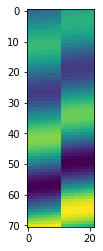

In [ ]:
print(new_array[20].shape)
#print(new_label[20].shape)
img=np.reshape(new_array[50], (71, 22))
plt.imshow(img)
print(new_label[50])


In [ ]:
from sklearn.model_selection import train_test_split

#split in dataset in train-test
X_train, X_test, y_train, y_test = train_test_split(new_array,new_label, test_size=0.20, stratify=new_label, random_state=42)

#split train in train-valid
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X_train,y_train, test_size=0.30, stratify=y_train, random_state=42)

In [ ]:
print("Dataset Split:")
print(f"Training : {len(Xtrain)}")
print(f"Validation : {len(Xvalid)}")
print(f"Testing : {len(X_test)}")

Dataset Split:
Training : 560
Validation : 240
Testing : 200


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
Xtrain = np.asarray(Xtrain)
ytrain = np.asarray(ytrain)
ytrain = ytrain.reshape(-1, 1)
X_test = np.asarray(X_test)
yvalid = np.asarray(yvalid)
yvalid = yvalid.reshape(-1, 1)
Xvalid = np.asarray(Xvalid)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1, 1)
encoder = OrdinalEncoder()
ytrain = encoder.fit_transform(ytrain)

yvalid = encoder.fit_transform(yvalid)

y_test = encoder.fit_transform(y_test)


In [ ]:
from sklearn.preprocessing import label_binarize
unique= np.unique(new_label, return_counts=True)
y_test_1 = label_binarize(y_test, classes=[0, 1, 2,3,4])
yvalid_1 = label_binarize(yvalid, classes=[0, 1, 2,3,4])
ytrain_1 = label_binarize(ytrain, classes=[0, 1, 2,3,4])
print(y_test_1[100])

[0 0 0 1 0]


In [ ]:
#model with 71x22 images
from keras.layers import GaussianNoise
def create_model():
  model = models.Sequential([

    layers.Conv2D(64, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    #model.add(layers.GaussianNoise(0.1))
    layers.Dense(5, activation='softmax'),
  ])
  return model

# Create a basic model instance
model_1 = create_model()

# Show a summary of the model. Check the number of trainable parameters
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 69, 20, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 69, 20, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 34, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 21760)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              22283264  
                                                                 
 dropout_4 (Dropout)         (None, 1024)             

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/Checkpoints/CNN_3"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
# This function keeps the initial learning rate for the first 5 epochs
# and decreases it exponentially after that.
def scheduler(num_epoch, lr):
  if num_epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
num_epochs = 30
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_1.fit(Xtrain, ytrain_1, epochs=num_epochs, callbacks=[ callback], batch_size=16, validation_data=(Xvalid, yvalid_1), verbose=1)
#model_1.save_weights('./model_1_weights', save_format='tf')

Epoch 1/30
35/35 [==============================] - 2s 28ms/step - loss: 10.5115 - accuracy: 0.4071 - val_loss: 1.4238 - val_accuracy: 0.2833 - lr: 0.0010
Epoch 2/30
35/35 [==============================] - 1s 20ms/step - loss: 2.9166 - accuracy: 0.5393 - val_loss: 1.5567 - val_accuracy: 0.1958 - lr: 0.0010
Epoch 3/30
35/35 [==============================] - 1s 23ms/step - loss: 1.0221 - accuracy: 0.6482 - val_loss: 1.5278 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 4/30
35/35 [==============================] - 1s 29ms/step - loss: 0.8557 - accuracy: 0.6482 - val_loss: 1.4271 - val_accuracy: 0.5958 - lr: 0.0010
Epoch 5/30
35/35 [==============================] - 1s 23ms/step - loss: 0.7134 - accuracy: 0.6893 - val_loss: 1.3916 - val_accuracy: 0.6792 - lr: 0.0010
Epoch 6/30
35/35 [==============================] - 1s 20ms/step - loss: 0.6180 - accuracy: 0.7375 - val_loss: 1.2994 - val_accuracy: 0.7083 - lr: 9.0484e-04
Epoch 7/30
35/35 [==============================] - 1s 20ms/step - loss

In [ ]:
os.listdir(checkpoint_dir)

['CNN_1',
 'CNN_2',
 'CNN_3',
 'results',
 'CNN_3.data-00000-of-00001',
 'CNN_3.index',
 'checkpoint']

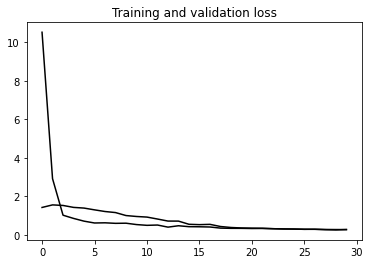

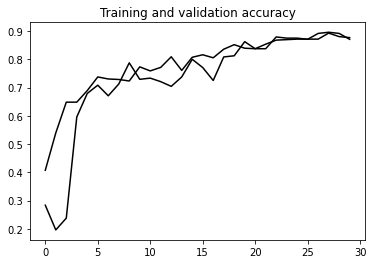

In [ ]:
import matplotlib.pyplot as plt

epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        42
         1.0       0.98      1.00      0.99        40
         2.0       1.00      0.82      0.90        34
         3.0       0.78      0.64      0.71        45
         4.0       0.70      0.95      0.80        39

    accuracy                           0.88       200
   macro avg       0.89      0.88      0.88       200
weighted avg       0.89      0.88      0.87       200

accuracy: 0.875
1
0


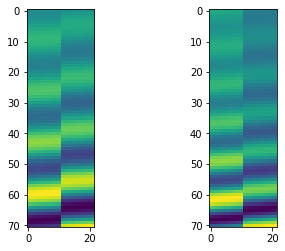

In [ ]:
#results:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model_1.predict(X_test),1)


print(sklearn.metrics.classification_report(y_test, y_pred))
a = accuracy_score(y_test, y_pred)
print("accuracy:",a)
plt.subplot(121)
img=np.reshape(X_test[20], (71, 22))
plt.imshow(img)

print(y_pred[20])
plt.subplot(122)
img_1=np.reshape(X_test[4], (71, 22))
plt.imshow(img_1)
print(y_pred[4])

In [ ]:
y_predicted = model_1.predict(X_test) #predict will return the scores of the model and predict_class will return the class of your predictions. Although it seems similar there are some differences:
pred_class = np.argmax(y_predicted, axis=1)  #argmax tra le colonne (axis =1)
#print(y_predicted)
#print(pred_class)

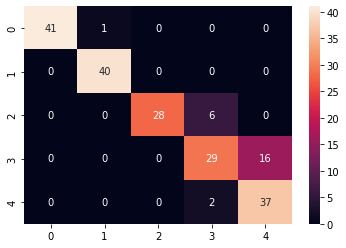

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test, pred_class)
#print(conf)
sns.heatmap(conf, annot=True, fmt="d")

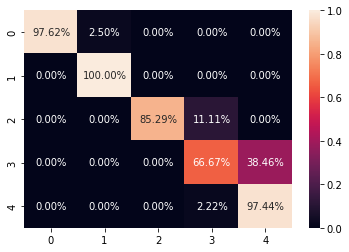

In [ ]:
cm = conf.astype('float') / conf.sum(axis=1)
sns.heatmap(cm, annot=True,
            fmt='.2%')

0.9734004466638825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


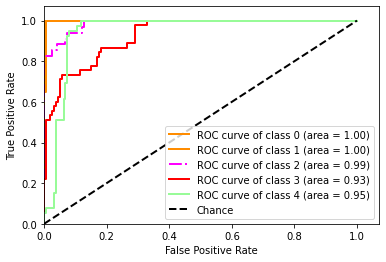

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from cycler import cycler
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_1[:,i], y_predicted[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
print(roc_auc["macro"])

# Plot all ROC curves
plt.figure(1)

colors = cycle(['darkorange', 'darkorange', 'magenta', 'red','palegreen'])

for i, color in zip(range(5), colors):
    linestyle_cycler = cycler('linestyle',['-','-','-.','-', '-'])
    plt.rc('axes', prop_cycle=linestyle_cycler)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Chance')
plt.xlim([0.0, 1.07])
plt.ylim([0.0, 1.07])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()




In [ ]:
#model with 71x22 images
from keras.layers import GaussianNoise
def create_model_2conv():
  model = models.Sequential([

    layers.Conv2D(32, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),


    layers.Dense(5, activation='softmax'),
  ])
  return model

# Create a basic model instance
model_2conv = create_model_2_a()

# Show a summary of the model. Check the number of trainable parameters
model_2conv.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 69, 20, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 69, 20, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 34, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 8, 64)         18496     
                                                                 
 batch_normalization_7 (Batc  (None, 32, 8, 64)        256       
 hNormalization)                                                 
                                                      

In [ ]:
# This function keeps the initial learning rate for the first 5 epochs
# and decreases it exponentially after that.
def scheduler(num_epoch, lr):
  if num_epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
num_epochs = 30
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


model_2conv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_2conv.fit(Xtrain, ytrain_1, epochs=num_epochs, callbacks=[ callback], batch_size=16, validation_data=(Xvalid, yvalid_1), verbose=1)
#model_1.save_weights('./model_1_weights', save_format='tf')

Epoch 1/30
35/35 [==============================] - 2s 19ms/step - loss: 4.5798 - accuracy: 0.4643 - val_loss: 1.1661 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 2/30
35/35 [==============================] - 0s 13ms/step - loss: 2.9211 - accuracy: 0.5875 - val_loss: 1.3184 - val_accuracy: 0.4250 - lr: 0.0010
Epoch 3/30
35/35 [==============================] - 0s 13ms/step - loss: 2.1833 - accuracy: 0.6018 - val_loss: 1.3628 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 4/30
35/35 [==============================] - 0s 13ms/step - loss: 1.4885 - accuracy: 0.6214 - val_loss: 1.5216 - val_accuracy: 0.3375 - lr: 0.0010
Epoch 5/30
35/35 [==============================] - 0s 13ms/step - loss: 1.3577 - accuracy: 0.6464 - val_loss: 1.8475 - val_accuracy: 0.2375 - lr: 0.0010
Epoch 6/30
35/35 [==============================] - 0s 13ms/step - loss: 1.0230 - accuracy: 0.6893 - val_loss: 1.5335 - val_accuracy: 0.4167 - lr: 9.0484e-04
Epoch 7/30
35/35 [==============================] - 0s 13ms/step - loss:

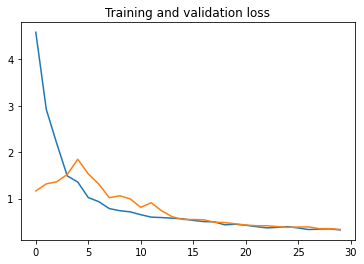

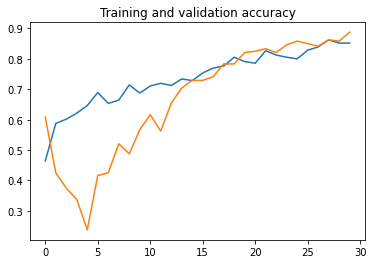

In [ ]:
import matplotlib.pyplot as plt

epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        42
         1.0       0.95      0.93      0.94        40
         2.0       0.91      0.88      0.90        34
         3.0       0.84      0.60      0.70        45
         4.0       0.67      0.95      0.79        39

    accuracy                           0.86       200
   macro avg       0.87      0.87      0.86       200
weighted avg       0.88      0.86      0.86       200

accuracy: 0.86
1
0


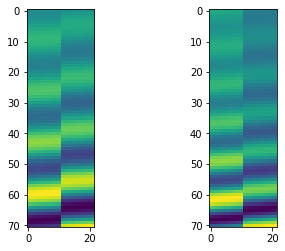

In [ ]:
#results:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model_2conv.predict(X_test),1)


print(sklearn.metrics.classification_report(y_test, y_pred))
a = accuracy_score(y_test, y_pred)
print("accuracy:",a)
plt.subplot(121)
img=np.reshape(X_test[20], (71, 22))
plt.imshow(img)

print(y_pred[20])
plt.subplot(122)
img_1=np.reshape(X_test[4], (71, 22))
plt.imshow(img_1)
print(y_pred[4])

##Experimental Dataset

In [ ]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/ExperimentalDataset'

# Creating the new dataset composed by multi-channels files

eco10

In [ ]:
import os, glob
from collections import defaultdict

dirs = ['/content/drive/MyDrive/Colab Notebooks/ExperimentalDataset/eco10/real', '/content/drive/MyDrive/Colab Notebooks/ExperimentalDataset/eco10/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10'
for unique_filename, copies in unique_files.items():
  #arr = np.array([genfromtxt(copy, delimiter=',') for copy in copies])
  arr= np.concatenate([genfromtxt(copy, delimiter=',') for copy in copies],axis=1)
  #arr = np.moveaxis(arr, 0, -1)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)
print(arr.shape)



(71, 22)


eco20

In [ ]:
import os, glob
from collections import defaultdict

dirs = ['/content/drive/MyDrive/Colab Notebooks/ExperimentalDataset/eco20/real', '/content/drive/MyDrive/Colab Notebooks/ExperimentalDataset/eco20/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco20'
for unique_filename, copies in unique_files.items():
  #arr = np.array([genfromtxt(copy, delimiter=',') for copy in copies])
  arr= np.concatenate([genfromtxt(copy, delimiter=',') for copy in copies],axis=1)
  #arr = np.moveaxis(arr, 0, -1)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)
print(arr.shape)

(71, 22)


eco30

In [ ]:
import os, glob
from collections import defaultdict

dirs = ['/content/drive/MyDrive/Colab Notebooks/ExperimentalDataset/eco30/real', '/content/drive/MyDrive/Colab Notebooks/ExperimentalDataset/eco30/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco30'
for unique_filename, copies in unique_files.items():
  #arr = np.array([genfromtxt(copy, delimiter=',') for copy in copies])
  arr= np.concatenate([genfromtxt(copy, delimiter=',') for copy in copies],axis=1)
  #arr = np.moveaxis(arr, 0, -1)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)
print(arr.shape)

(71, 22)


eco10-10%

In [ ]:
import os, glob
from collections import defaultdict

dirs = ['/content/drive/MyDrive/Colab Notebooks/ExperimentalDataset/eco10-10%/real', '/content/drive/MyDrive/Colab Notebooks/ExperimentalDataset/eco10-10%/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10-10%'
for unique_filename, copies in unique_files.items():
  #arr = np.array([genfromtxt(copy, delimiter=',') for copy in copies])
  arr= np.concatenate([genfromtxt(copy, delimiter=',') for copy in copies],axis=1)
  #arr = np.moveaxis(arr, 0, -1)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)
print(arr.shape)

(71, 22)


eco10-20%

In [ ]:
import os, glob
from collections import defaultdict

dirs = ['/content/drive/MyDrive/Colab Notebooks/ExperimentalDataset/eco10-20%/real', '/content/drive/MyDrive/Colab Notebooks/ExperimentalDataset/eco10-20%/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10-20%'
for unique_filename, copies in unique_files.items():
  #arr = np.array([genfromtxt(copy, delimiter=',') for copy in copies])
  arr= np.concatenate([genfromtxt(copy, delimiter=',') for copy in copies],axis=1)
  #arr = np.moveaxis(arr, 0, -1)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)
print(arr.shape)

(71, 22)


# Dataset

In [ ]:
new_root_dir_exp = '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp'

In [ ]:
def preprocessing(path,path_mu1, path_mu2, path_mu3, path_mu4, path_mu5):
 imgs_array = []
 label_array = []
 cartelle = [j for j in sorted(os.listdir(path))]

 for folder in cartelle:
   if folder.startswith('eco10-20%'):
     immagini_mu1 = [i for i in sorted(os.listdir(path_mu1))]
     for image in immagini_mu1:
       images = np.load(os.path.join(path_mu1, image))
       images = images.reshape(71,22,1)
       #x = img_to_array(images)
       label_array.append(1)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('eco10-10%'):
     immagini_mu2 = [i for i in sorted(os.listdir(path_mu2))]
     for image in immagini_mu2:
       images = np.load(os.path.join(path_mu2, image))
       images = images.reshape(71,22,1)
       label_array.append(2)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('eco10'):
     immagini_mu3 = [i for i in sorted(os.listdir(path_mu3))]
     for image in immagini_mu3:
       images = np.load(os.path.join(path_mu3, image))
       images = images.reshape(71,22,1)
       label_array.append(3)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('eco20'):
     immagini_mu4 = [i for i in sorted(os.listdir(path_mu4))]
     for image in immagini_mu4:
       images = np.load(os.path.join(path_mu4, image))
       images = images.reshape(71,22,1)
       label_array.append(4)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('eco30'):
     immagini_mu5 = [i for i in sorted(os.listdir(path_mu5))]
     for image in immagini_mu5:
       images = np.load(os.path.join(path_mu5, image))
       images = images.reshape(71,22,1)
       label_array.append(5)
       imgs_array.append(images) #images are added to a list


 return imgs_array, label_array

In [ ]:
from sklearn.utils import shuffle
path_eco10_20= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10-20%'
path_eco10_10= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10-10%'
path_eco10= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10'
path_eco20= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco20'
path_eco30= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco30'


#preprocessing and shuffle
new_array_exp_, new_label_exp_ = preprocessing(new_root_dir_exp, path_eco10_20, path_eco10_10, path_eco10, path_eco20, path_eco30)
new_array_exp, new_label_exp = shuffle(new_array_exp_,new_label_exp_, random_state=24) #Random state allows to obtain the same shuffle over time

(71, 22, 1)
3


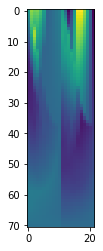

In [ ]:
print(new_array_exp[10].shape)
#print(new_label[20].shape)
img=np.reshape(new_array_exp[11], (71, 22))
plt.imshow(img)
print(new_label_exp[11])


In [ ]:
from sklearn.model_selection import train_test_split

#split in dataset in train-test
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(new_array_exp,new_label_exp, test_size=0.20, stratify=new_label_exp, random_state=42)

#split train in train-valid
Xtrain_exp, Xvalid_exp, ytrain_exp, yvalid_exp = train_test_split(X_train_exp,y_train_exp, test_size=0.30, stratify=y_train_exp, random_state=42)

In [ ]:
print("Dataset Split:")
print(f"Training : {len(Xtrain_exp)}")
print(f"Validation : {len(Xvalid_exp)}")
print(f"Testing : {len(X_test_exp)}")

Dataset Split:
Training : 203
Validation : 88
Testing : 73


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
Xtrain_exp = np.asarray(Xtrain_exp)
ytrain_exp = np.asarray(ytrain_exp)
ytrain_exp = ytrain_exp.reshape(-1, 1)
X_test_exp = np.asarray(X_test_exp)
y_test_exp = np.asarray(y_test_exp)
y_test_exp = y_test_exp.reshape(-1, 1)
yvalid_exp = np.asarray(yvalid_exp)
yvalid_exp = yvalid_exp.reshape(-1, 1)
Xvalid_exp = np.asarray(Xvalid_exp)

encoder = OrdinalEncoder()
ytrain_exp = encoder.fit_transform(ytrain_exp)

yvalid_exp = encoder.fit_transform(yvalid_exp)

y_test_exp = encoder.fit_transform(y_test_exp)


# **Data Augmentation**

In [ ]:
#This is just an example of data augmentation: there are so many functions that you can use!
import tensorflow as tf

def flip_axis(x, axis):
    cp = np.copy(x)
    cp = np.asarray(cp).swapaxes(axis, 0)
    cp = cp[::-1, ...]
    cp = cp.swapaxes(0, axis)
    return cp


def augment_data(dataset, dataset_labels, augementation_factor=1, use_flip_axis=True, use_random_rotation=True, use_random_shear=True, use_random_shift=True):
    augmented_image = []
    augmented_image_labels = []

    for num in range (0, dataset.shape[0]):
			# original image:
       augmented_image.append(dataset[num])
       augmented_image_labels.append(dataset_labels[num])

       for i in range(0, augementation_factor):

            # flipping
            if use_flip_axis:
                augmented_image.append(flip_axis(dataset[num],1))
                augmented_image_labels.append(dataset_labels[num])

            #random rotation
            if use_random_rotation:
                augmented_image.append(tf.keras.preprocessing.image.random_rotation(dataset[num], 150, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                augmented_image_labels.append(dataset_labels[num])
            #if use_random_rotation:
               # augmented_image.append(tf.keras.preprocessing.image.random_rotation(dataset[num], 180, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
               # augmented_image_labels.append(dataset_labels[num])
            #random spatial shear
            if use_random_shear:
                augmented_image.append(tf.keras.preprocessing.image.random_shear(dataset[num], 0.2, row_axis=0, col_axis=1, channel_axis=0))
                augmented_image_labels.append(dataset_labels[num])
            #random spatial shift
            if use_random_shift:
                augmented_image.append(tf.keras.preprocessing.image.random_shift(dataset[num], 0.2, 0.2, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                augmented_image_labels.append(dataset_labels[num])
            #if use_random_brightness:
               #augmented_image.append(tf.keras.preprocessing.image.random_brightness(dataset[num], [0.2, 0.5]))
               #augmented_image_labels.append(dataset_labels[num])

    return np.array(augmented_image), np.array(augmented_image_labels)


In [ ]:
#apply data augmentation
img_augmented_exp, label_augmented_exp = augment_data(Xtrain_exp, ytrain_exp, augementation_factor=1, use_flip_axis=True,
                                                      use_random_rotation=True, use_random_shear=True, use_random_shift=True)

In [ ]:
print(img_augmented_exp.shape)
print(Xtrain_exp.shape)

(1015, 71, 22, 1)
(203, 71, 22, 1)


[2.]
[4.]


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


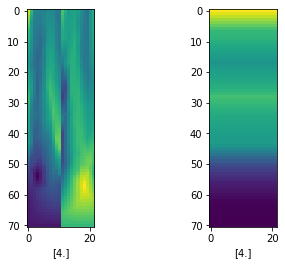

In [ ]:
plt.subplot(121)
img=np.reshape(img_augmented_exp[36], (71, 22))
plt.imshow(img)
plt.xlabel(label_augmented_exp[36])
print(label_augmented_exp[34])

plt.subplot(122)
img=np.reshape(img_augmented_exp[37], (71, 22))
plt.imshow(img)
plt.xlabel(label_augmented_exp[37])
print(label_augmented_exp[37])

In [ ]:
from sklearn.preprocessing import label_binarize

y_test_exp_1 = label_binarize(y_test_exp, classes=[0, 1, 2,3,4])
yvalid_exp_1 = label_binarize(yvalid_exp, classes=[0, 1, 2,3,4])
label_augmented_exp_1 = label_binarize(label_augmented_exp, classes=[0, 1, 2,3,4])
print(y_test_exp_1[10])

[0 0 1 0 0]


##CNN Model

In [ ]:
# Create the model
model_exp = models.Sequential()

# Add new layers
model_exp.add(layers.Conv2D(64, 3, activation='relu', input_shape=(71,11,2)))
model_exp.add(layers.MaxPooling2D((2, 2)))
model_exp.add(layers.Flatten())
model_exp.add(layers.Dense(1024, activation='relu'))

model_exp.add(layers.Dense(512, activation='relu'))

model_exp.add(layers.Dense(5, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model_exp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 9, 64)         1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 4, 64)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8704)              0         
                                                                 
 dense (Dense)               (None, 1024)              8913920   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 5)                 2565      
                                                        

In [ ]:
num_epochs = 30
model_exp.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_exp.fit(Xtrain, ytrain, epochs=num_epochs, batch_size=16, validation_data=(Xvalid_exp, yvalid_exp), verbose=1)

Epoch 1/30
35/35 [==============================] - 1s 16ms/step - loss: 1.5755 - accuracy: 0.4143 - val_loss: 1.6159 - val_accuracy: 0.1364
Epoch 2/30
35/35 [==============================] - 0s 10ms/step - loss: 1.4631 - accuracy: 0.6464 - val_loss: 1.6230 - val_accuracy: 0.1364
Epoch 3/30
35/35 [==============================] - 0s 10ms/step - loss: 1.3305 - accuracy: 0.6732 - val_loss: 1.6327 - val_accuracy: 0.1136
Epoch 4/30
35/35 [==============================] - 0s 10ms/step - loss: 1.1615 - accuracy: 0.7161 - val_loss: 1.6378 - val_accuracy: 0.1023
Epoch 5/30
35/35 [==============================] - 0s 9ms/step - loss: 0.9737 - accuracy: 0.7179 - val_loss: 1.6552 - val_accuracy: 0.1023
Epoch 6/30
35/35 [==============================] - 0s 9ms/step - loss: 0.7962 - accuracy: 0.7357 - val_loss: 1.6805 - val_accuracy: 0.1023
Epoch 7/30
35/35 [==============================] - 0s 9ms/step - loss: 0.6834 - accuracy: 0.7482 - val_loss: 1.6857 - val_accuracy: 0.0795
Epoch 8/30
35/35

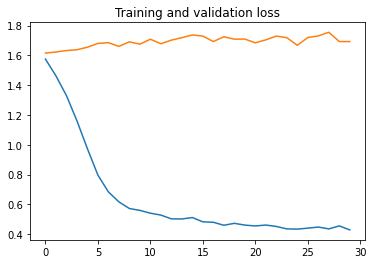

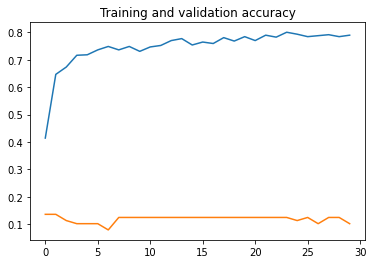

In [ ]:
import matplotlib.pyplot as plt

epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")

##Fine tuning


In [ ]:
model_2 = Model(inputs = model_1.input, outputs=model_1.output[:-2])
model_2.summary()
# Freeze all layers except the last one.
for layer in model_2.layers[:-6]:
  layer.trainable = False

for layer in model_2.layers:
    print(layer, layer.trainable)

#model_exp = Sequential() #A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
#model_exp.add(model_2)
#model_exp.add(layers.Dense(5, activation='softmax'))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 71, 22, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 69, 20, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 69, 20, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 10, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 21760)             0         
                                                                 
 dense (Dense)               (None, 1024)              2228

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.

def scheduler(num_epoch, lr):
  if num_epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
num_epochs = 30

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_exp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_exp.fit(img_augmented_exp, label_augmented_exp, epochs=num_epochs, callbacks= [callback], batch_size=16, validation_data=(Xvalid_exp, yvalid_exp), verbose=1)


Epoch 1/30


InvalidArgumentError: ignored

##Model_exp

In [ ]:
#model with 71x22 images
from keras.layers import GaussianNoise
def create_model_2():
  model = models.Sequential([

    layers.Conv2D(64, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    #layers.Dense(512, activation='relu'),
    #layers.Dropout(0.5),

    layers.Dense(5, activation='softmax'),
  ])
  return model

# Create a basic model instance
model_2 = create_model_2()

# Show a summary of the model. Check the number of trainable parameters
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 69, 20, 64)        640       
                                                                 
 batch_normalization_4 (Batc  (None, 69, 20, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 34, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 21760)             0         
                                                                 
 dense_12 (Dense)            (None, 1024)              22283264  
                                                                 
 dropout_8 (Dropout)         (None, 1024)             

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.

def scheduler(num_epoch, lr):
  if num_epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
num_epochs = 50

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_2.fit(img_augmented_exp, label_augmented_exp_1, epochs=num_epochs , batch_size=12, validation_data=(Xvalid_exp, yvalid_exp_1), verbose=1)


Epoch 1/50
85/85 [==============================] - 2s 16ms/step - loss: 1.5593 - accuracy: 0.3025 - val_loss: 1.5747 - val_accuracy: 0.4318
Epoch 2/50
85/85 [==============================] - 1s 7ms/step - loss: 1.3402 - accuracy: 0.4798 - val_loss: 1.5345 - val_accuracy: 0.4318
Epoch 3/50
85/85 [==============================] - 1s 7ms/step - loss: 1.2244 - accuracy: 0.5271 - val_loss: 1.4771 - val_accuracy: 0.5682
Epoch 4/50
85/85 [==============================] - 1s 7ms/step - loss: 1.1385 - accuracy: 0.5468 - val_loss: 1.4030 - val_accuracy: 0.6477
Epoch 5/50
85/85 [==============================] - 1s 7ms/step - loss: 1.0714 - accuracy: 0.6039 - val_loss: 1.2960 - val_accuracy: 0.6932
Epoch 6/50
85/85 [==============================] - 1s 8ms/step - loss: 1.0094 - accuracy: 0.6207 - val_loss: 1.1683 - val_accuracy: 0.6818
Epoch 7/50
85/85 [==============================] - 1s 7ms/step - loss: 0.9838 - accuracy: 0.6315 - val_loss: 1.0599 - val_accuracy: 0.6818
Epoch 8/50
85/85 [=

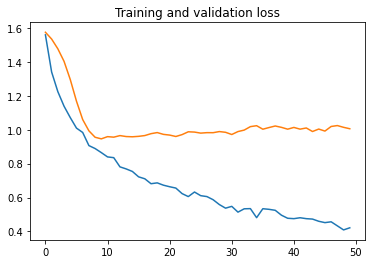

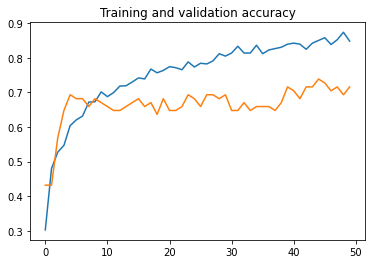

In [ ]:
import matplotlib.pyplot as plt

epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")

              precision    recall  f1-score   support

         0.0       0.60      0.55      0.57        11
         1.0       0.83      1.00      0.91        10
         2.0       0.72      0.94      0.82        31
         3.0       0.80      0.36      0.50        11
         4.0       0.67      0.40      0.50        10

    accuracy                           0.73        73
   macro avg       0.72      0.65      0.66        73
weighted avg       0.72      0.73      0.70        73

accuracy: 0.726027397260274
4
0


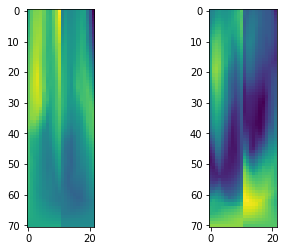

In [ ]:
#results:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#y_pred = model.predict_classes(X_test)
y_pred_exp= np.argmax(model_2.predict(X_test_exp, batch_size=16),1)


print(sklearn.metrics.classification_report(y_test_exp, y_pred_exp))
a = accuracy_score(y_test_exp, y_pred_exp)
print("accuracy:",a)
plt.subplot(121)
img=np.reshape(X_test_exp[20], (71, 22))
plt.imshow(img)

print(y_pred_exp[20])
plt.subplot(122)
img_1=np.reshape(X_test_exp[4], (71, 22))
plt.imshow(img_1)
print(y_pred_exp[4])

In [ ]:
y_predicted_exp = model_2.predict(X_test_exp) #predict will return the scores of the model and predict_class will return the class of your predictions. Although it seems similar there are some differences:
pred_class_exp = np.argmax(y_predicted_exp, axis=1)  #argmax tra le colonne (axis =1)


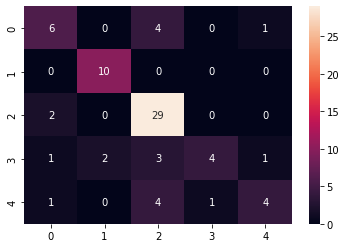

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test_exp, pred_class_exp)
#print(conf)
sns.heatmap(conf, annot=True, fmt="d")

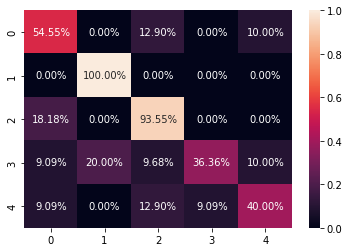

In [ ]:
cm = conf.astype('float') / conf.sum(axis=1)
sns.heatmap(cm, annot=True,
            fmt='.2%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9258803810364685


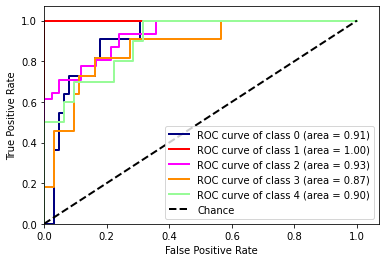

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from cycler import cycler
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr_exp = dict()
tpr_exp = dict()
roc_auc_exp = dict()
for i in range(5):
    fpr_exp[i], tpr_exp[i], _ = roc_curve(y_test_exp_1[:,i], y_predicted_exp[:,i])
    roc_auc_exp[i] = auc(fpr_exp[i], tpr_exp[i])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr_exp = np.unique(np.concatenate([fpr_exp[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr_exp = np.zeros_like(all_fpr_exp)
for i in range(5):
    mean_tpr_exp += interp(all_fpr_exp, fpr_exp[i], tpr_exp[i])

# Finally average it and compute AUC
mean_tpr_exp /= 5

fpr_exp["macro"] = all_fpr_exp
tpr_exp["macro"] = mean_tpr_exp
roc_auc_exp["macro"] = auc(fpr_exp["macro"], tpr_exp["macro"])
print(roc_auc_exp["macro"])

# Plot all ROC curves
plt.figure(1)

colors = cycle(['navy', 'red', 'magenta', 'darkorange','palegreen'])

for i, color in zip(range(5), colors):
    linestyle_cycler = cycler('linestyle',['-','-','-','-', '-'])
    plt.rc('axes', prop_cycle=linestyle_cycler)
    plt.plot(fpr_exp[i], tpr_exp[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_exp[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Chance')
plt.xlim([0.0, 1.07])
plt.ylim([0.0, 1.07])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()




In [ ]:
print(roc_auc_exp["macro"])

0.9258803810364685


In [ ]:
#model with 71x22 images
from keras.layers import GaussianNoise
def create_model_2_a():
  model = models.Sequential([

    layers.Conv2D(32, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),


    layers.Dense(5, activation='softmax'),
  ])
  return model

# Create a basic model instance
model_2_a = create_model_2_a()

# Show a summary of the model. Check the number of trainable parameters
model_2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 69, 20, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 69, 20, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 34, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 8, 64)         18496     
                                                                 
 batch_normalization_9 (Batc  (None, 32, 8, 64)        256       
 hNormalization)                                                 
                                                      

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.

def scheduler(num_epoch, lr):
  if num_epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
num_epochs = 30

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_2_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_2_a.fit(img_augmented_exp, label_augmented_exp_1, epochs=num_epochs , batch_size=12, validation_data=(Xvalid_exp, yvalid_exp_1), verbose=1)


Epoch 1/30
85/85 [==============================] - 4s 24ms/step - loss: 1.9338 - accuracy: 0.4138 - val_loss: 1.6048 - val_accuracy: 0.1818
Epoch 2/30
85/85 [==============================] - 1s 14ms/step - loss: 1.3823 - accuracy: 0.5360 - val_loss: 1.5430 - val_accuracy: 0.4318
Epoch 3/30
85/85 [==============================] - 1s 13ms/step - loss: 1.1378 - accuracy: 0.5823 - val_loss: 1.7427 - val_accuracy: 0.1932
Epoch 4/30
85/85 [==============================] - 1s 11ms/step - loss: 1.0285 - accuracy: 0.6355 - val_loss: 1.6531 - val_accuracy: 0.2841
Epoch 5/30
85/85 [==============================] - 1s 10ms/step - loss: 0.9144 - accuracy: 0.6493 - val_loss: 1.4298 - val_accuracy: 0.4545
Epoch 6/30
85/85 [==============================] - 1s 10ms/step - loss: 0.8341 - accuracy: 0.6995 - val_loss: 1.1634 - val_accuracy: 0.5795
Epoch 7/30
85/85 [==============================] - 1s 10ms/step - loss: 0.7897 - accuracy: 0.7241 - val_loss: 1.0573 - val_accuracy: 0.6364
Epoch 8/30
85

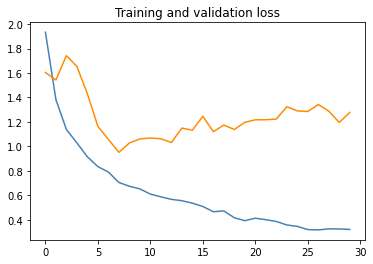

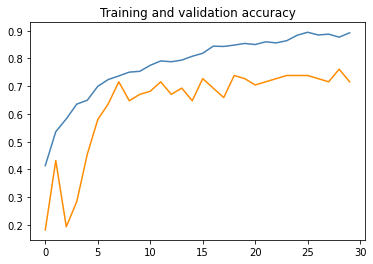

In [ ]:
import matplotlib.pyplot as plt

epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs),history.history["loss"], label="train_loss", color= 'steelblue')
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss", color='darkorange')

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc",  color='steelblue')
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc",  color='darkorange')

              precision    recall  f1-score   support

         0.0       0.56      0.45      0.50        11
         1.0       0.91      1.00      0.95        10
         2.0       0.65      0.90      0.76        31
         3.0       0.83      0.45      0.59        11
         4.0       0.50      0.20      0.29        10

    accuracy                           0.68        73
   macro avg       0.69      0.60      0.62        73
weighted avg       0.68      0.68      0.65        73

accuracy: 0.684931506849315
4
0


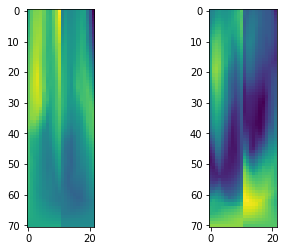

In [ ]:
#results:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#y_pred = model.predict_classes(X_test)
y_pred_exp= np.argmax(model_2_a.predict(X_test_exp, batch_size=16),1)


print(sklearn.metrics.classification_report(y_test_exp, y_pred_exp))
a = accuracy_score(y_test_exp, y_pred_exp)
print("accuracy:",a)
plt.subplot(121)
img=np.reshape(X_test_exp[20], (71, 22))
plt.imshow(img)

print(y_pred_exp[20])
plt.subplot(122)
img_1=np.reshape(X_test_exp[4], (71, 22))
plt.imshow(img_1)
print(y_pred_exp[4])

In [ ]:
y_predicted_exp = model_2_a.predict(X_test_exp) #predict will return the scores of the model and predict_class will return the class of your predictions. Although it seems similar there are some differences:
pred_class_exp = np.argmax(y_predicted_exp, axis=1)  #argmax tra le colonne (axis =1)


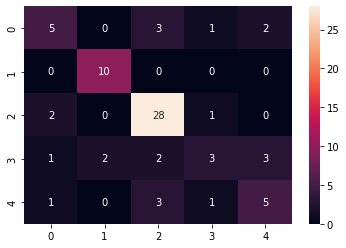

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test_exp, pred_class_exp)
#print(conf)
sns.heatmap(conf, annot=True, fmt="d")

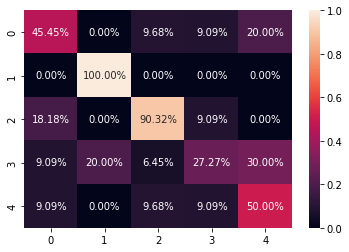

In [ ]:
cm = conf.astype('float') / conf.sum(axis=1)
sns.heatmap(cm, annot=True,
            fmt='.2%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


0.9211753029026702


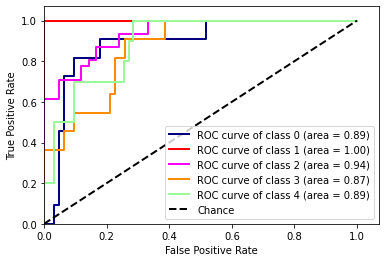

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from cycler import cycler
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr_exp = dict()
tpr_exp = dict()
roc_auc_exp = dict()
for i in range(5):
    fpr_exp[i], tpr_exp[i], _ = roc_curve(y_test_exp_1[:,i], y_predicted_exp[:,i])
    roc_auc_exp[i] = auc(fpr_exp[i], tpr_exp[i])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr_exp = np.unique(np.concatenate([fpr_exp[i] for i in range(5)]))

# Then interpolate all ROC curves at this points
mean_tpr_exp = np.zeros_like(all_fpr_exp)
for i in range(5):
    mean_tpr_exp += interp(all_fpr_exp, fpr_exp[i], tpr_exp[i])

# Finally average it and compute AUC
mean_tpr_exp /= 5

fpr_exp["macro"] = all_fpr_exp
tpr_exp["macro"] = mean_tpr_exp
roc_auc_exp["macro"] = auc(fpr_exp["macro"], tpr_exp["macro"])
print(roc_auc_exp["macro"])

# Plot all ROC curves
plt.figure(1)

colors = cycle(['navy', 'red', 'magenta', 'darkorange','palegreen'])

for i, color in zip(range(5), colors):
    linestyle_cycler = cycler('linestyle',['-','-','-','-', '-'])
    plt.rc('axes', prop_cycle=linestyle_cycler)
    plt.plot(fpr_exp[i], tpr_exp[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc_exp[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw, label='Chance')
plt.xlim([0.0, 1.07])
plt.ylim([0.0, 1.07])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()




## Two Classes

In [ ]:
new_root_dir_exp = '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp'

In [ ]:
def preprocessing(path, path_mu1, path_mu5):
 imgs_array = []
 label_array = []
 cartelle = [j for j in sorted(os.listdir(path))]

 for folder in cartelle:


   if folder.startswith('eco10-20%'):
     immagini_mu1 = [i for i in sorted(os.listdir(path_mu1))]
     for image in immagini_mu1:
       images = np.load(os.path.join(path_mu1, image))
       images = images.reshape(71,22,1)
       label_array.append(1)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('eco30'):
     immagini_mu5 = [i for i in sorted(os.listdir(path_mu5))]
     for image in immagini_mu5:
       images = np.load(os.path.join(path_mu5, image))
       images = images.reshape(71,22,1)
       label_array.append(5)
       imgs_array.append(images) #images are added to a list



 return imgs_array, label_array

In [ ]:
from sklearn.utils import shuffle
#path_eco10_10= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10-10%'
#path_eco10= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10'
path_eco10_20= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10-20%'
path_eco30= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco30'
#preprocessing and shuffle
newarray_3, newlabel_3 = preprocessing(new_root_dir_exp,  path_eco10_20, path_eco30)
new_array_3, new_label_3 = shuffle(newarray_3,newlabel_3, random_state=24) #Random state allows to obtain the same shuffle over time

Text(0.5, 0, '5')

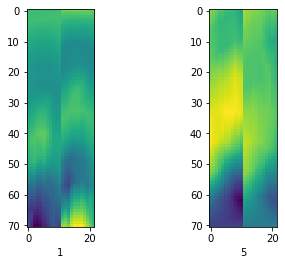

In [ ]:
plt.subplot(121)
img=np.reshape(newarray_3[1], (71, 22))
plt.imshow(img)
plt.xlabel(newlabel_3[1])

plt.subplot(122)
img=np.reshape(newarray_3[103], (71, 22))
plt.imshow(img)
plt.xlabel(newlabel_3[103])


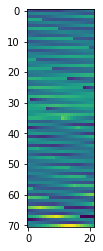

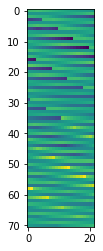

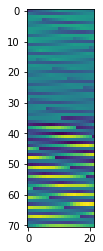

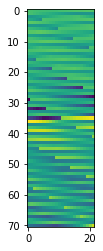

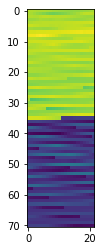

In [ ]:
for i, image in enumerate(newarray_3):
  if i<5:
    plt.figure()
    image = image.transpose((1, 2, 0))
    image=np.reshape(image, (71,22))
    plt.imshow(image)


In [ ]:
from sklearn.model_selection import train_test_split

#split in dataset in train-test
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(new_array_3,new_label_3, test_size=0.30, stratify=new_label_3, random_state=42)

#split train in train-valid
Xtrain_3, Xvalid_3, ytrain_3, yvalid_3 = train_test_split(X_train_3,y_train_3, test_size=0.30, stratify=y_train_3, random_state=42)

In [ ]:
print("Dataset Split:")
print(f"Training : {len(Xtrain_3)}")
print(f"Validation : {len(Xvalid_3)}")
print(f"Testing : {len(X_test_3)}")

Dataset Split:
Training : 50
Validation : 22
Testing : 32


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
Xtrain_3 = np.asarray(Xtrain_3)
ytrain_3 = np.asarray(ytrain_3)
ytrain_3 = ytrain_3.reshape(-1, 1)
X_test_3 = np.asarray(X_test_3)
y_test_3 = np.asarray(y_test_3)
y_test_3 = y_test_3.reshape(-1, 1)
yvalid_3 = np.asarray(yvalid_3)
yvalid_3 = yvalid_3.reshape(-1, 1)
Xvalid_3 = np.asarray(Xvalid_3)

encoder = OrdinalEncoder()
ytrain_3 = encoder.fit_transform(ytrain_3)

yvalid_3 = encoder.fit_transform(yvalid_3)

y_test_3 = encoder.fit_transform(y_test_3)


# **Data Augmentation**

In [ ]:
#This is just an example of data augmentation: there are so many functions that you can use!
import tensorflow as tf

def flip_axis(x, axis):
    cp = np.copy(x)
    cp = np.asarray(cp).swapaxes(axis, 0)
    cp = cp[::-1, ...]
    cp = cp.swapaxes(0, axis)
    return cp


def augment_data(dataset, dataset_labels, augementation_factor=2, use_flip_axis=True, use_random_rotation=True, use_random_shear=True, use_random_shift=True, use_random_brightness= True):
    augmented_image = []
    augmented_image_labels = []

    for num in range (0, dataset.shape[0]):
			# original image:
       augmented_image.append(dataset[num])
       augmented_image_labels.append(dataset_labels[num])

       for i in range(0, augementation_factor):

            # flipping
            if use_flip_axis:
                augmented_image.append(flip_axis(dataset[num],1))
                augmented_image_labels.append(dataset_labels[num])

            #random rotation
            #if use_random_rotation:
               # augmented_image.append(tf.keras.preprocessing.image.random_rotation(dataset[num], 40, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                #augmented_image_labels.append(dataset_labels[num])
            if use_random_rotation:
                augmented_image.append(tf.keras.preprocessing.image.random_rotation(dataset[num], 150, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                augmented_image_labels.append(dataset_labels[num])
            #random spatial shear
            if use_random_shear:
                augmented_image.append(tf.keras.preprocessing.image.random_shear(dataset[num], 0.2, row_axis=0, col_axis=1, channel_axis=0))
                augmented_image_labels.append(dataset_labels[num])
            #random spatial shift
            if use_random_shift:
                augmented_image.append(tf.keras.preprocessing.image.random_shift(dataset[num], 0.2, 0.2, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                augmented_image_labels.append(dataset_labels[num])
            if use_random_brightness:
               augmented_image.append(tf.keras.preprocessing.image.random_brightness(dataset[num], [0.2, 0.5]))
               augmented_image_labels.append(dataset_labels[num])

    return np.array(augmented_image), np.array(augmented_image_labels)


In [ ]:
#apply data augmentation
img_augmented_3, label_augmented_3 = augment_data(Xtrain_3, ytrain_3, augementation_factor=2, use_flip_axis=True,
                                                      use_random_rotation=True, use_random_shear=True, use_random_shift=True, use_random_brightness= True)

In [ ]:
print(img_augmented_3.shape)
print(Xtrain_3.shape)

(550, 71, 22, 1)
(50, 71, 22, 1)


[0.]
[0.]


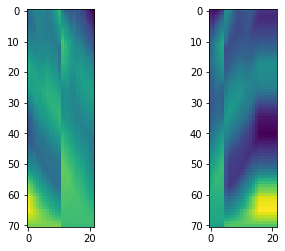

In [ ]:
plt.subplot(121)
img=np.reshape(img_augmented_3[34], (71, 22))
plt.imshow(img)
print(label_augmented_3[34])

plt.subplot(122)
img=np.reshape(img_augmented_3[35], (71, 22))
plt.imshow(img)
print(label_augmented_3[35])

##Model_3

In [ ]:
#model with 71x22 images
from keras.layers import GaussianNoise
def create_model_3():
  model = models.Sequential([

    layers.Conv2D(64, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(2, activation='softmax'),
  ])
  return model

# Create a basic model instance
model_3 = create_model_3()

# Show a summary of the model. Check the number of trainable parameters
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 69, 20, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 69, 20, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 34, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 21760)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              22283264  
                                                                 
 dropout_4 (Dropout)         (None, 1024)             

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.

def scheduler(num_epoch, lr):
  if num_epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
num_epochs = 30

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_3.fit(img_augmented_3, label_augmented_3, epochs=num_epochs, batch_size=12, validation_data=(Xvalid_3, yvalid_3), verbose=1)


Epoch 1/30
46/46 [==============================] - 2s 25ms/step - loss: 2.4918 - accuracy: 0.5291 - val_loss: 0.9514 - val_accuracy: 0.5000
Epoch 2/30
46/46 [==============================] - 1s 20ms/step - loss: 2.3563 - accuracy: 0.5891 - val_loss: 1.1267 - val_accuracy: 0.5000
Epoch 3/30
46/46 [==============================] - 1s 20ms/step - loss: 2.7832 - accuracy: 0.5964 - val_loss: 0.6895 - val_accuracy: 0.5000
Epoch 4/30
46/46 [==============================] - 1s 21ms/step - loss: 1.6363 - accuracy: 0.6655 - val_loss: 0.6582 - val_accuracy: 0.5909
Epoch 5/30
46/46 [==============================] - 1s 20ms/step - loss: 2.1816 - accuracy: 0.6655 - val_loss: 0.7217 - val_accuracy: 0.5000
Epoch 6/30
46/46 [==============================] - 1s 21ms/step - loss: 1.6950 - accuracy: 0.6673 - val_loss: 0.6504 - val_accuracy: 0.5000
Epoch 7/30
46/46 [==============================] - 1s 20ms/step - loss: 1.7897 - accuracy: 0.7055 - val_loss: 0.6318 - val_accuracy: 0.6364
Epoch 8/30
46

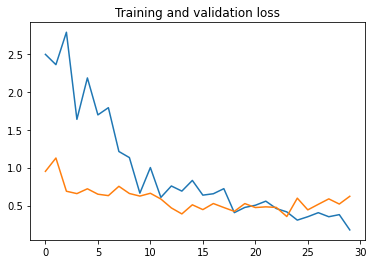

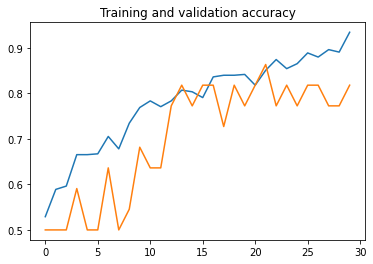

In [ ]:
import matplotlib.pyplot as plt

epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")

In [ ]:
X_test_3_a = np.squeeze(X_test_3, axis=3)
print(X_test_3_a.shape)

(32, 71, 22)


              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84        16
         1.0       0.82      0.88      0.85        16

    accuracy                           0.84        32
   macro avg       0.85      0.84      0.84        32
weighted avg       0.85      0.84      0.84        32

accuracy: 0.84375
0
1


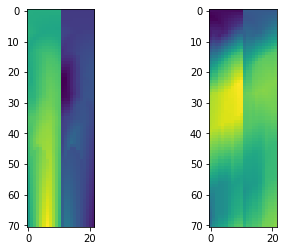

In [ ]:
#results:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#y_pred = model.predict_classes(X_test)
y_pred_3= np.argmax(model_3.predict(X_test_3),1)


print(sklearn.metrics.classification_report(y_test_3, y_pred_3))
a = accuracy_score(y_test_3, y_pred_3)
print("accuracy:",a)
plt.subplot(121)
img=np.reshape(X_test_3[20], (71, 22))
plt.imshow(img)

print(y_pred_3[20])
plt.subplot(122)
img_1=np.reshape(X_test_3[4], (71, 22))
plt.imshow(img_1)
print(y_pred_3[4])

In [ ]:
y_predicted_3 = model_3.predict(X_test_3_a) #predict will return the scores of the model and predict_class will return the class of your predictions. Although it seems similar there are some differences:
pred_class_3 = np.argmax(y_predicted_3, axis=1)  #argmax tra le colonne (axis =1)


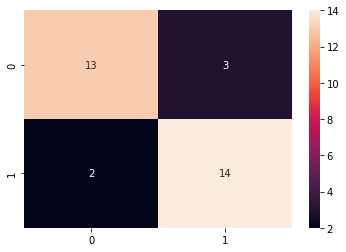

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test_3, pred_class_3)
#print(conf)
sns.heatmap(conf, annot=True, fmt="d")

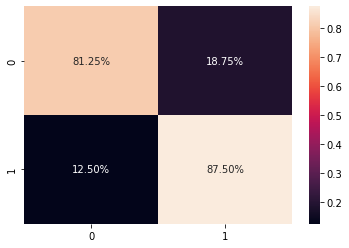

In [ ]:
cm = conf.astype('float') / conf.sum(axis=1)
sns.heatmap(cm, annot=True,
            fmt='.2%')

In [ ]:
from sklearn.metrics import roc_curve

fpr_model_2vs2_exp, tpr_model_2vs2_exp, thresholds_model_2vs2_exp = roc_curve(y_test_3, y_predicted_3[:,1])

In [ ]:
from sklearn.metrics import auc
auc_model_2vs2_exp = auc(fpr_model_2vs2_exp, tpr_model_2vs2_exp)

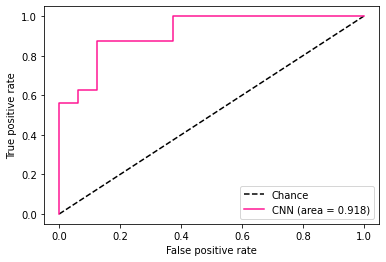

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.plot(fpr_model_2vs2_exp, tpr_model_2vs2_exp, color='deeppink', label='CNN (area = {:.3f})'.format(auc_model_2vs2_exp))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

plt.legend(loc='best')
plt.show()


In [ ]:
#model with 71x22 images
from keras.layers import GaussianNoise
def create_model_2_a():
  model = models.Sequential([

    layers.Conv2D(32, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),


    layers.Dense(5, activation='softmax'),
  ])
  return model

# Create a basic model instance
model_2_a = create_model_2_a()

# Show a summary of the model. Check the number of trainable parameters
model_2_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 69, 20, 32)        320       
                                                                 
 batch_normalization_2 (Batc  (None, 69, 20, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 34, 10, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 8, 64)         18496     
                                                                 
 batch_normalization_3 (Batc  (None, 32, 8, 64)        256       
 hNormalization)                                                 
                                                      

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.

def scheduler(num_epoch, lr):
  if num_epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
num_epochs = 30

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_2_a.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_2_a.fit(img_augmented_3, label_augmented_3, epochs=num_epochs, batch_size=12, validation_data=(Xvalid_3, yvalid_3), verbose=1)


Epoch 1/30
46/46 [==============================] - 2s 18ms/step - loss: 3.7110 - accuracy: 0.5891 - val_loss: 0.7278 - val_accuracy: 0.3636
Epoch 2/30
46/46 [==============================] - 1s 11ms/step - loss: 3.2078 - accuracy: 0.6618 - val_loss: 1.6887 - val_accuracy: 0.5000
Epoch 3/30
46/46 [==============================] - 1s 12ms/step - loss: 1.8128 - accuracy: 0.7455 - val_loss: 0.7707 - val_accuracy: 0.5000
Epoch 4/30
46/46 [==============================] - 1s 13ms/step - loss: 1.6909 - accuracy: 0.7709 - val_loss: 1.5340 - val_accuracy: 0.5000
Epoch 5/30
46/46 [==============================] - 1s 12ms/step - loss: 1.1279 - accuracy: 0.8218 - val_loss: 1.1868 - val_accuracy: 0.5000
Epoch 6/30
46/46 [==============================] - 1s 13ms/step - loss: 1.0765 - accuracy: 0.8145 - val_loss: 0.8494 - val_accuracy: 0.5000
Epoch 7/30
46/46 [==============================] - 1s 12ms/step - loss: 0.8906 - accuracy: 0.8345 - val_loss: 0.8477 - val_accuracy: 0.5000
Epoch 8/30
46

In [ ]:
X_test_3_a = np.squeeze(X_test_3, axis=3)
print(X_test_3_a.shape)

y_test_3_a = np.squeeze(y_test_3, axis=1)
print(X_test_3_a.shape)

(32, 71, 22)
(32, 71, 22)


              precision    recall  f1-score   support

         0.0       1.00      0.81      0.90        16
         1.0       0.84      1.00      0.91        16

    accuracy                           0.91        32
   macro avg       0.92      0.91      0.91        32
weighted avg       0.92      0.91      0.91        32

accuracy: 0.90625
0
1


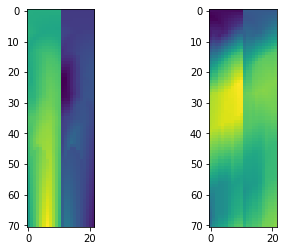

In [ ]:
#results:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#y_pred = model.predict_classes(X_test)
y_pred_3= np.argmax(model_2_a.predict(X_test_3_a),1)


print(sklearn.metrics.classification_report(y_test_3_a, y_pred_3))
a = accuracy_score(y_test_3_a, y_pred_3)
print("accuracy:",a)
plt.subplot(121)
img=np.reshape(X_test_3[20], (71, 22))
plt.imshow(img)

print(y_pred_3[20])
plt.subplot(122)
img_1=np.reshape(X_test_3[4], (71, 22))
plt.imshow(img_1)
print(y_pred_3[4])

## Four Classes

mu1

In [ ]:
import os, glob
from collections import defaultdict

dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu1/real', '/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu1/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu1'
for unique_filename, copies in unique_files.items():
  arr= np.stack([genfromtxt(copy, delimiter=',') for copy in copies],axis=0)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)

print(arr.shape)

(71, 22)


mu2

In [ ]:
dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu2/real', '/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu2/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu1'
for unique_filename, copies in unique_files.items():
  arr= np.stack([genfromtxt(copy, delimiter=',') for copy in copies],axis=0)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)

print(arr.shape)

(71, 22)


mu3

In [ ]:
dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu3/real', '/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu3/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu1'
for unique_filename, copies in unique_files.items():
  arr= np.stack([genfromtxt(copy, delimiter=',') for copy in copies],axis=0)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)

print(arr.shape)

(71, 22)


mu4

In [ ]:
dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu4/real', '/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu4/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu1'
for unique_filename, copies in unique_files.items():
  arr= np.stack([genfromtxt(copy, delimiter=',') for copy in copies],axis=0)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)

print(arr.shape)

(71, 22)


mu5

In [ ]:
dirs = ['/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu5/real', '/content/drive/MyDrive/Colab Notebooks/Simulated_Dataset/mu5/imag']
file_pattrn = r'*.csv'
unique_files = defaultdict(list)

for d in dirs:
  for i in glob.iglob(os.path.join(d, file_pattrn)):
     unique_files[os.path.basename(i)].append(i)

In [ ]:
destination = '/content/drive/MyDrive/Colab Notebooks/New_Dataset/mu1'
for unique_filename, copies in unique_files.items():
  arr= np.stack([genfromtxt(copy, delimiter=',') for copy in copies],axis=0)
  np.save(os.path.join(destination, unique_filename), arr, allow_pickle=True)

print(arr.shape)

(71, 22)


In [ ]:
new_root_dir_exp = '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp'

In [ ]:
def preprocessing(path,path_mu1, path_mu2, path_mu3,path_mu5):
 imgs_array = []
 label_array = []
 cartelle = [j for j in sorted(os.listdir(path))]

 for folder in cartelle:
   if folder.startswith('eco10-20%'):
     immagini_mu1 = [i for i in sorted(os.listdir(path_mu1))]
     for image in immagini_mu1:
       images = np.load(os.path.join(path_mu1, image))
       images = images.reshape(71,22,1)
       #x = img_to_array(images)
       label_array.append(1)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('eco10-10%'):
     immagini_mu2 = [i for i in sorted(os.listdir(path_mu2))]
     for image in immagini_mu2:
       images = np.load(os.path.join(path_mu2, image))
       images = images.reshape(71,22,1)
       label_array.append(2)
       imgs_array.append(images) #images are added to a list

   if folder.startswith('eco10'):
     immagini_mu3 = [i for i in sorted(os.listdir(path_mu3))]
     for image in immagini_mu3:
       images = np.load(os.path.join(path_mu3, image))
       images = images.reshape(71,22,1)
       label_array.append(3)
       imgs_array.append(images) #images are added to a list


   if folder.startswith('eco30'):
     immagini_mu5 = [i for i in sorted(os.listdir(path_mu5))]
     for image in immagini_mu5:
       images = np.load(os.path.join(path_mu5, image))
       images = images.reshape(71,22,1)
       label_array.append(5)
       imgs_array.append(images) #images are added to a list


 return imgs_array, label_array

In [ ]:
from sklearn.utils import shuffle
path_eco10_20= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10-20%'
path_eco10_10= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10-10%'
path_eco30= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco30'
path_eco10= '/content/drive/MyDrive/Colab Notebooks/New_DatasetExp/eco10'

#preprocessing and shuffle
new_array_4, new_label_4 = preprocessing(new_root_dir_exp, path_eco10_20, path_eco10_10, path_eco10, path_eco30)
new_array_4, new_label_4 = shuffle(new_array_4,new_label_4, random_state=24) #Random state allows to obtain the same shuffle over time

(71, 22, 1)
3


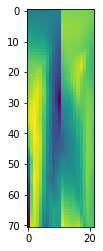

In [ ]:
print(new_array_4[10].shape)
#print(new_label[20].shape)
img=np.reshape(new_array_4[10], (71, 22))
plt.imshow(img)
print(new_label_4[10])


In [ ]:
from sklearn.model_selection import train_test_split

#split in dataset in train-test
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(new_array_4,new_label_4, test_size=0.20, stratify=new_label_4, random_state=42)

#split train in train-valid
Xtrain_4, Xvalid_4, ytrain_4, yvalid_4 = train_test_split(X_train_4,y_train_4, test_size=0.30, stratify=y_train_4, random_state=42)

In [ ]:
print("Dataset Split:")
print(f"Training : {len(Xtrain_4)}")
print(f"Validation : {len(Xvalid_4)}")
print(f"Testing : {len(X_test_4)}")

Dataset Split:
Training : 174
Validation : 75
Testing : 63


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
Xtrain_4 = np.asarray(Xtrain_4)
ytrain_4 = np.asarray(ytrain_4)
ytrain_4 = ytrain_4.reshape(-1, 1)
X_test_4 = np.asarray(X_test_4)
y_test_4 = np.asarray(y_test_4)
y_test_4 = y_test_4.reshape(-1, 1)
yvalid_4 = np.asarray(yvalid_4)
yvalid_4 = yvalid_4.reshape(-1, 1)
Xvalid_4 = np.asarray(Xvalid_4)

encoder = OrdinalEncoder()
ytrain_4 = encoder.fit_transform(ytrain_4)

yvalid_4 = encoder.fit_transform(yvalid_4)

y_test_4 = encoder.fit_transform(y_test_4)


# **Data Augmentation**

In [ ]:
#This is just an example of data augmentation: there are so many functions that you can use!
import tensorflow as tf

def flip_axis(x, axis):
    cp = np.copy(x)
    cp = np.asarray(cp).swapaxes(axis, 0)
    cp = cp[::-1, ...]
    cp = cp.swapaxes(0, axis)
    return cp


def augment_data(dataset, dataset_labels, augementation_factor=1, use_flip_axis=True, use_random_rotation=True, use_random_shear=True, use_random_shift=True, use_random_brightness= True):
    augmented_image = []
    augmented_image_labels = []

    for num in range (0, dataset.shape[0]):
			# original image:
       augmented_image.append(dataset[num])
       augmented_image_labels.append(dataset_labels[num])

       for i in range(0, augementation_factor):

            # flipping
            if use_flip_axis:
                augmented_image.append(flip_axis(dataset[num],1))
                augmented_image_labels.append(dataset_labels[num])

            #random rotation
            #if use_random_rotation:
               # augmented_image.append(tf.keras.preprocessing.image.random_rotation(dataset[num], 40, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                #augmented_image_labels.append(dataset_labels[num])
            if use_random_rotation:
                augmented_image.append(tf.keras.preprocessing.image.random_rotation(dataset[num], 180, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                augmented_image_labels.append(dataset_labels[num])
            #random spatial shear
            if use_random_shear:
                augmented_image.append(tf.keras.preprocessing.image.random_shear(dataset[num], 0.2, row_axis=0, col_axis=1, channel_axis=0))
                augmented_image_labels.append(dataset_labels[num])
            #random spatial shift
            if use_random_shift:
                augmented_image.append(tf.keras.preprocessing.image.random_shift(dataset[num], 0.2, 0.2, row_axis=1, col_axis=2, channel_axis=0, fill_mode='nearest'))
                augmented_image_labels.append(dataset_labels[num])
            if use_random_brightness:
               augmented_image.append(tf.keras.preprocessing.image.random_brightness(dataset[num], [0.2, 0.5]))
               augmented_image_labels.append(dataset_labels[num])

    return np.array(augmented_image), np.array(augmented_image_labels)


In [ ]:
#apply data augmentation
img_augmented_4, label_augmented_4 = augment_data(Xtrain_4, ytrain_4, augementation_factor=1, use_flip_axis=True,
                                                      use_random_rotation=True, use_random_shear=True, use_random_shift=True, use_random_brightness= False)

In [ ]:
print(img_augmented_4.shape)
print(Xtrain_4.shape)

(870, 71, 22, 1)
(174, 71, 22, 1)


[2.]
[2.]


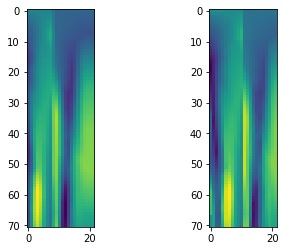

In [ ]:
plt.subplot(121)
img=np.reshape(img_augmented_4[34], (71, 22))
plt.imshow(img)
print(label_augmented_4[34])

plt.subplot(122)
img=np.reshape(img_augmented_4[35], (71, 22))
plt.imshow(img)
print(label_augmented_4[35])

##Model_4

In [ ]:
#model with 71x22 images
from keras.layers import GaussianNoise
def create_model_4():
  model = models.Sequential([

    layers.Conv2D(64, 3, activation='relu', input_shape=(71,22,1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(4, activation='softmax'),
  ])
  return model

# Create a basic model instance
model_4 = create_model_4()

# Show a summary of the model. Check the number of trainable parameters
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 69, 20, 64)        640       
                                                                 
 batch_normalization_2 (Batc  (None, 69, 20, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 34, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 21760)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               11141632  
                                                                 
 dropout_3 (Dropout)         (None, 512)              

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.

def scheduler(num_epoch, lr):
  if num_epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
num_epochs = 20

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model_4.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model_4.fit(img_augmented_4, label_augmented_4, epochs=num_epochs,  batch_size=12, validation_data=(Xvalid_4, yvalid_4), verbose=1)


Epoch 1/20
73/73 [==============================] - 7s 93ms/step - loss: 1.2169 - accuracy: 0.4414 - val_loss: 1.3350 - val_accuracy: 0.4933
Epoch 2/20
73/73 [==============================] - 6s 85ms/step - loss: 0.9640 - accuracy: 0.6138 - val_loss: 1.2985 - val_accuracy: 0.4933
Epoch 3/20
73/73 [==============================] - 6s 86ms/step - loss: 0.8605 - accuracy: 0.6667 - val_loss: 1.2554 - val_accuracy: 0.6533
Epoch 4/20
73/73 [==============================] - 6s 85ms/step - loss: 0.7866 - accuracy: 0.6828 - val_loss: 1.1833 - val_accuracy: 0.7467
Epoch 5/20
73/73 [==============================] - 6s 86ms/step - loss: 0.7218 - accuracy: 0.7379 - val_loss: 1.1002 - val_accuracy: 0.7867
Epoch 6/20
73/73 [==============================] - 6s 86ms/step - loss: 0.6604 - accuracy: 0.7586 - val_loss: 0.9779 - val_accuracy: 0.7867
Epoch 7/20
73/73 [==============================] - 6s 86ms/step - loss: 0.6460 - accuracy: 0.7736 - val_loss: 0.8411 - val_accuracy: 0.7867
Epoch 8/20
73

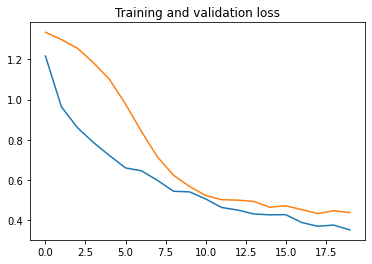

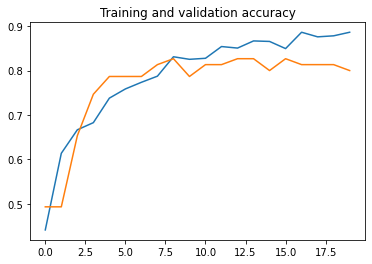

In [ ]:
import matplotlib.pyplot as plt

epochs = num_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation accuracy')
plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")

              precision    recall  f1-score   support

         0.0       0.64      0.64      0.64        11
         1.0       0.82      0.90      0.86        10
         2.0       0.86      0.94      0.90        32
         3.0       1.00      0.60      0.75        10

    accuracy                           0.83        63
   macro avg       0.83      0.77      0.78        63
weighted avg       0.84      0.83      0.82        63

accuracy: 0.8253968253968254
2
0


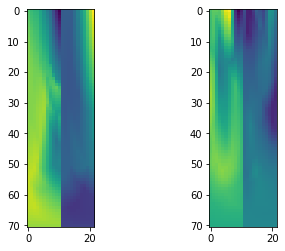

In [ ]:
#results:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#y_pred = model.predict_classes(X_test)
y_pred_4= np.argmax(model_4.predict(X_test_4),1)


print(sklearn.metrics.classification_report(y_test_4, y_pred_4))
a = accuracy_score(y_test_4, y_pred_4)
print("accuracy:",a)
plt.subplot(121)
img=np.reshape(X_test_4[20], (71, 22))
plt.imshow(img)

print(y_pred_4[20])
plt.subplot(122)
img_1=np.reshape(X_test_4[4], (71, 22))
plt.imshow(img_1)
print(y_pred_4[4])

In [ ]:
y_predicted_4 = model_4.predict(X_test_4) #predict will return the scores of the model and predict_class will return the class of your predictions. Although it seems similar there are some differences:
pred_class_4 = np.argmax(y_predicted_4, axis=1)  #argmax tra le colonne (axis =1)


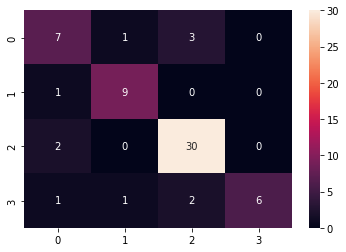

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf = confusion_matrix(y_test_4, pred_class_4)
#print(conf)
sns.heatmap(conf, annot=True, fmt="d")

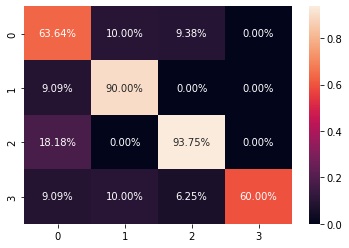

In [ ]:
cm = conf.astype('float') / conf.sum(axis=1)
sns.heatmap(cm, annot=True,
            fmt='.2%')